In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bread26","key":"0fb1694249a104e64cb364ca7572ed42"}'}

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

 53% 1.00M/1.90M [00:00<00:00, 1.99MB/s]
100% 1.90M/1.90M [00:00<00:00, 3.24MB/s]


In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import warnings
warnings.simplefilter("ignore")

from tensorflow.keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [7]:
EMBEDDING_DIM = 100
MAXLEN = 16
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 6000
TRAINING_SPLIT = 0.8

In [8]:
import zipfile
!unzip /content/sentiment-analysis-on-movie-reviews.zip

Archive:  /content/sentiment-analysis-on-movie-reviews.zip
  inflating: sampleSubmission.csv    
  inflating: test.tsv.zip            
  inflating: train.tsv.zip           


In [9]:
train = pd.read_csv('/content/train.tsv.zip',sep = '\t')
test = pd.read_csv('/content/test.tsv.zip',sep = '\t')

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [10]:
def train_val_split(sentences, labels, training_split):
    train_data, validation_data, train_labels, validation_labels = train_test_split(sentences, labels, train_size=training_split, random_state=42)
    return train_data, validation_data, train_labels, validation_labels
    
    return train_data, validation_data, train_labels, validation_labels

In [11]:
kalimat = train["Phrase"]
label = train["Sentiment"]
train_sentences, val_sentences, train_labels, val_labels = train_val_split(kalimat, label, TRAINING_SPLIT)

In [12]:
def token(train_sentences, oov_token):
    tokenizer = Tokenizer(oov_token = oov_token, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)      
    tokenizer.fit_on_texts(train_sentences)

    return tokenizer

In [13]:
tokenizer = token(train_sentences, OOV_TOKEN)

indeks_kata = tokenizer.word_index
size = len(indeks_kata)

print("Jumlah Kata = ", size)
print(indeks_kata)

Jumlah Kata =  15277
{'<OOV>': 1, 'the': 2, 'a': 3, 'of': 4, 'and': 5, 'to': 6, "'s": 7, 'in': 8, 'is': 9, 'that': 10, 'it': 11, 'as': 12, 'for': 13, 'with': 14, 'its': 15, 'film': 16, 'an': 17, 'movie': 18, 'this': 19, 'but': 20, 'be': 21, 'on': 22, 'you': 23, 'by': 24, "n't": 25, 'more': 26, 'his': 27, 'one': 28, 'about': 29, 'not': 30, 'at': 31, 'or': 32, 'than': 33, 'all': 34, 'from': 35, 'like': 36, 'have': 37, 'are': 38, 'has': 39, 'so': 40, "'": 41, 'out': 42, 'story': 43, 'up': 44, 'rrb': 45, 'who': 46, 'too': 47, 'most': 48, 'good': 49, 'into': 50, 'lrb': 51, 'what': 52, 'if': 53, 'their': 54, 'time': 55, 'characters': 56, 'no': 57, 'much': 58, 'i': 59, "''": 60, 'comedy': 61, 'your': 62, 'can': 63, 'just': 64, 'some': 65, 'life': 66, 'does': 67, 'even': 68, 'little': 69, 'funny': 70, 'will': 71, 'way': 72, 'well': 73, 'been': 74, 'very': 75, 'any': 76, 'only': 77, 'make': 78, 'movies': 79, 'which': 80, 'he': 81, 'director': 82, 'love': 83, 'bad': 84, 'do': 85, 'work': 86, 'th

In [14]:
def pad_truncate(sentences, tokenizer, padding, truncating, maxlen):  
    sequences = tokenizer.texts_to_sequences(sentences)
    padding_truncating = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)
    
    return padding_truncating

In [15]:
train_pad_trunc_seq = pad_truncate(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = pad_truncate(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

In [16]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [17]:
from sklearn.preprocessing import LabelEncoder
encode = LabelEncoder()
train_labels = encode.fit_transform(train_labels)
val_labels = encode.fit_transform(val_labels)

In [18]:
def modelling(vocab_size, embedding_dim, maxlen):
    model = tf.keras.Sequential([ 
        tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=maxlen, trainable=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer='adam',
                  metrics=['accuracy']) 
    
    return model

In [19]:
model = modelling(size, EMBEDDING_DIM, MAXLEN)
z = model.fit(train_pad_trunc_seq, train_labels, epochs=20, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/20
3902/3902 [==============================] - 210s 52ms/step - loss: 0.9505 - accuracy: 0.6162 - val_loss: 0.8426 - val_accuracy: 0.6559
Epoch 2/20
3902/3902 [==============================] - 205s 53ms/step - loss: 0.7561 - accuracy: 0.6882 - val_loss: 0.8012 - val_accuracy: 0.6707
Epoch 3/20
3902/3902 [==============================] - 205s 52ms/step - loss: 0.6705 - accuracy: 0.7208 - val_loss: 0.8136 - val_accuracy: 0.6707
Epoch 4/20
3902/3902 [==============================] - 205s 52ms/step - loss: 0.6037 - accuracy: 0.7475 - val_loss: 0.8534 - val_accuracy: 0.6645
Epoch 5/20
3902/3902 [==============================] - 209s 54ms/step - loss: 0.5423 - accuracy: 0.7714 - val_loss: 0.9231 - val_accuracy: 0.6626
Epoch 6/20
3902/3902 [==============================] - 205s 53ms/step - loss: 0.4868 - accuracy: 0.7930 - val_loss: 0.9914 - val_accuracy: 0.6563
Epoch 7/20
3902/3902 [==============================] - 203s 52ms/step - loss: 0.4358 - accuracy: 0.8126 - val_loss: 1

In [20]:
testing = test["Phrase"]
tokens = token(testing, OOV_TOKEN)

pad_truncate_test = pad_truncate(testing, tokens, PADDING,TRUNCATING,MAXLEN)


In [21]:
sen = np.argmax(model.predict(pad_truncate_test), axis=-1)
test['Sentiment']= sen

2072/2072 [==============================] - 26s 12ms/step


In [22]:
test = test.drop(['Phrase','SentenceId'],axis = 1)
test.head()

,PhraseId,Sentiment
0,156061,1
1,156062,1
2,156063,2
3,156064,1
4,156065,1


In [24]:
test.to_csv("result.csv",index = False)

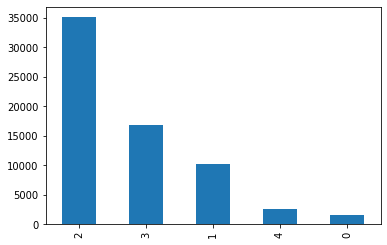

In [25]:
test["Sentiment"].value_counts().plot(kind="bar")

###The sentiment labels are:

*   0 - negative
*   1 - somewhat negative
*   2 - neutral
*   3 - somewhat positive
*   4 - positive